# AnaVerse 2.0_J – Sensor Anomaly Detection


#### Problem Statement:

In [1]:
#Predict anomalies (0/1) in an energy manufacturing plant

#using sensor readings captured at regular intervals.

### 1. Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline 
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [4]:
#Classical ML models

from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier

In [5]:
#Advanced models

from sklearn.ensemble import RandomForestClassifier

In [6]:
#XGBoost 

from xgboost import XGBClassifier 
xgb_available = True

sns.set(style="whitegrid")

### 2. Load Dataset

In [7]:
train_df = pd.read_parquet('train.parquet') 
test_df = pd.read_parquet('test.parquet') 

In [8]:
print("Train shape:", train_df.shape)

Train shape: (1639424, 7)


In [9]:
print("Test shape:", test_df.shape)

Test shape: (409856, 7)


In [10]:
train_df.head(5)

,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


In [11]:
test_df.head(5)

,ID,Date,X1,X2,X3,X4,X5
0,0,2020-12-16,1.685395,5.463917,1.0,7.389056,2.890372
1,1,2020-12-16,1.488844,5.454936,1.0,7.389056,2.890372
2,2,2020-12-16,1.164160,5.471136,1.0,1.000000,2.890372
3,3,2020-12-16,1.000000,5.467385,1.0,1.000000,2.890372
4,4,2020-12-16,1.000000,5.453995,1.0,1.000000,2.833213


### 3. Exploratory Data Analysis (EDA)

In [12]:
# EDA questions:

# 1. Is the dataset imbalanced?

# 2. Which sensors move together?

# 3. Do anomalies show extreme behavior?


In [13]:
# Basic structure

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639424 entries, 0 to 1639423
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1639424 non-null  datetime64[ns]
 1   X1      1639424 non-null  float64       
 2   X2      1639424 non-null  float64       
 3   X3      1639424 non-null  float64       
 4   X4      1639424 non-null  float64       
 5   X5      1639424 non-null  float64       
 6   target  1639424 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 87.6+ MB


 Target Distribution (0 = Normal, 1 = Anomaly)
target
0    0.991437
1    0.008563
Name: proportion, dtype: float64


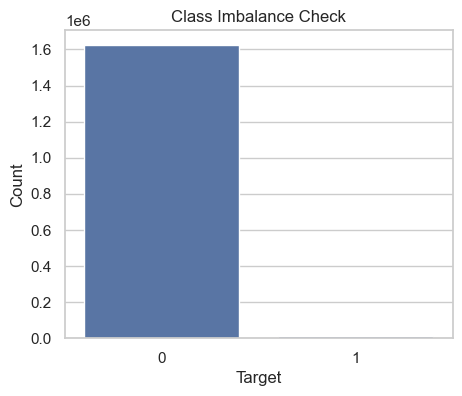

In [14]:
# Target distribution

print(" Target Distribution (0 = Normal, 1 = Anomaly)") 
print(train_df['target'].value_counts(normalize=True))

plt.figure(figsize=(5,4)) 
sns.countplot(x='target', data=train_df) 
plt.title('Class Imbalance Check') 
plt.xlabel('Target') 
plt.ylabel('Count') 
plt.show()

In [ ]:
# Sensor distributions by class

sensor_cols = ['X1','X2','X3','X4','X5']

for col in sensor_cols: 
    plt.figure(figsize=(5,3)) 
    sns.kdeplot(data=train_df, x=col, hue='target', fill=True) 
plt.title(f'Distribution of {col} by Class') 
plt.show()

In [ ]:
# Correlation heatmap

plt.figure(figsize=(8,6)) 
sns.heatmap(train_df.drop(columns=['Date']).corr(), annot=True, cmap='coolwarm', fmt='.2f') 
plt.title('Feature Correlation Heatmap') 
plt.show()

### 4. Data Cleaning & Preprocessing

In [ ]:
# Cleaning strategy:

# 1. Handle missing values

# 2. Detect and cap outliers

# 3. Ensure data consistency

In [ ]:
# Missing Values

train_df.isna().sum()

In [ ]:
test_df.isna().sum()

In [ ]:
train_df.fillna(train_df.median(numeric_only=True), inplace=True)

In [ ]:
test_df.fillna(test_df.median(numeric_only=True), inplace=True)

In [ ]:
# Outlier Treatment (IQR Method)

# - Sensor data often contains spikes. instead of removal, we cap them

sensor_cols = ['X1','X2','X3','X4','X5']

for col in sensor_cols: 
    Q1 = train_df[col].quantile(0.25) 
    Q3 = train_df[col].quantile(0.75) 
    IQR = Q3 - Q1 
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR

train_df[col] = np.clip(train_df[col], lower_bound, upper_bound)
test_df[col]  = np.clip(test_df[col], lower_bound, upper_bound)

In [ ]:
# Post-cleaning sanity check

train_df.describe()

In [ ]:
# Missing value handling (robust median strategy)

train_df.fillna(train_df.median(numeric_only=True), inplace=True) 
test_df.fillna(test_df.median(numeric_only=True), inplace=True)

### 5. Feature Engineering

In [ ]:
# Idea:

# Anomalies often appear when sensors disagree or fluctuate sharply.

# We engineer statistical and interaction-based features to capture this.

for df in [train_df, test_df]: 
    df['sensor_mean'] = df[['X1','X2','X3','X4','X5']].mean(axis=1) 
    df['sensor_std']  = df[['X1','X2','X3','X4','X5']].std(axis=1) 
    df['sensor_max']  = df[['X1','X2','X3','X4','X5']].max(axis=1) 
    df['sensor_min']  = df[['X1','X2','X3','X4','X5']].min(axis=1) 
    df['sensor_range'] = df['sensor_max'] - df['sensor_min']

In [ ]:
# Visual validation of engineered features

plt.figure(figsize=(5,3)) 
sns.boxplot(x=train_df['target'], y=train_df['sensor_std']) 
plt.title('Sensor Volatility vs Anomaly') 
plt.show()

In [ ]:
# Drop datetime 

X = train_df.drop(columns=['target', 'Date']) 
y = train_df['target'] 
X_test = test_df.drop(columns=['Date'])

In [ ]:
# Train-validation split with stratification

X_train, X_val, y_train, y_val = train_test_split( 
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y )

### 6. Evaluation Helper Function

In [ ]:
def evaluate_model(name, model, X_val, y_val): 
    preds = model.predict(X_val)

    y_true = y_val.astype(int)
    y_pred = pd.Series(preds).astype(int)

    print(f"\n{name} Performance")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
    print("F1 Score :", f1_score(y_true, y_pred, zero_division=0))
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

### 7. Model Training – Classical & Advanced Models

In [ ]:
# Strategy:

# Start with classical baselines

# Compare against ensemble & boosting models

# Evaluate using F1-score

In [ ]:
# ✅ Make sure target is integer before splitting
train_df["target"] = train_df["target"].astype(int)

X = train_df.drop(columns=["target", "Date"])
y = train_df["target"].astype(int)   # <-- force int here
X_test = test_df.drop(columns=["Date"])

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000))
    ]),

    "Support Vector Machine": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearSVC(dual="auto", class_weight="balanced", random_state=42))
    ]),

    "KNN": Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier(n_neighbors=5))
    ]),

    "Decision Tree": DecisionTreeClassifier(
        max_depth=6,
        random_state=42
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=150,
        max_depth=8,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),

    "XGBoost": XGBClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        eval_metric='logloss',
        random_state=42
    )
}

trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    evaluate_model(name, model, X_val, y_val)
    trained_models[name] = model

### 8. Hyperparameter Tuning (Random Forest)

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,         
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_
print('Best RF Params:', random_search.best_params_)
evaluate_model('Tuned Random Forest', best_rf, X_val, y_val)

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

grid = GridSearchCV(rf, param_grid, scoring='f1', cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print('Best RF Params:', grid.best_params_)
evaluate_model('Tuned Random Forest', best_rf, X_val, y_val)

### 9. Final Training & Submission

In [ ]:
best_rf.fit(X, y)
final_preds = best_rf.predict(X_test).astype(int)

submission = sample_submission.copy()
submission['target'] = final_preds

submission.to_parquet('submission.parquet', index=False)

print('Submission saved as submission.parquet')